[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/open-atmos/PySDM.git/main?urlpath=examples/PySDM_examples/deJong_Azimi/rainshaft.ipynb)
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/open-atmos/PySDM/blob/main/examples/PySDM_examples/deJong_Azimi/rainshaft.ipynb)

#### Derived from the precipitation case of Fig. 1 from Shipway & Hill 2012, but with no condensation/evaporation (collisions only). For further information, see Shipway_Hill_2012 example.

**NOTES**: 
- constant momentum profile rather than constant velocity profile is used herein
- sedimentation and collisions are the only active dynamics
- pressure at z=0 not given in the paper, assumed (see settings.py)
- domain extended below z=0 to mimic particle inflow via updraft

In [1]:
import sys
if 'google.colab' in sys.modules:
    !pip --quiet install open-atmos-jupyter-utils
    from open_atmos_jupyter_utils import pip_install_on_colab
    pip_install_on_colab('PySDM-examples')

In [2]:
from PySDM_examples.Shipway_and_Hill_2012 import plot
from PySDM_examples.deJong_Azimi import Settings1D, Simulation
from PySDM.physics import si
from PySDM.exporters import NetCDFExporter_1d
import numpy as np
import matplotlib.pyplot as plt 

## Collisions Only Test Case

In [3]:
common_params = {
    "n_sd_per_gridbox": 128,
    "dt": 10 * si.s,
    "dz": 50 * si.m,
    "particles_per_volume_STP": 10 / si.cm**3,
    "t_max": 1000 * si.s
}
output = {}
settings = {}
simulation = {}
for rho_times_w in (
    0 * si.kg/si.m**3 * si.m/si.s,
):
    key = f"rhow={rho_times_w}"
    settings[key] = Settings1D(
        **common_params,
        rho_times_w_1=rho_times_w,
    )
    simulation[key] = Simulation(settings[key])
    output[key] = simulation[key].run().products


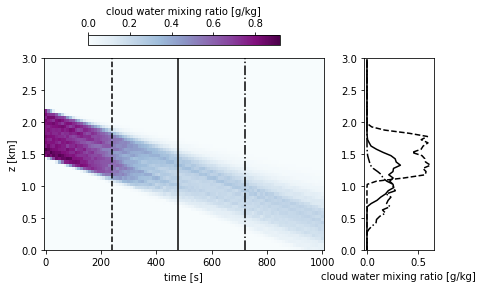

HTML(value="<a href='./qc_rhow=0.pdf' target='_blank'>./qc_rhow=0.pdf</a><br>")

In [4]:
for rho_times_w in (0,):
    plot(var='cloud water mixing ratio', qlabel='cloud water mixing ratio [g/kg]', fname=f'qc_rhow={rho_times_w}.pdf',
            output=output[f'rhow={rho_times_w}.0'],
            line = {0: ":", 4: "--", 8: "-", 12: "-."})

In [5]:
output[f'rhow={rho_times_w}.0']['nc'].max()

8915432.82

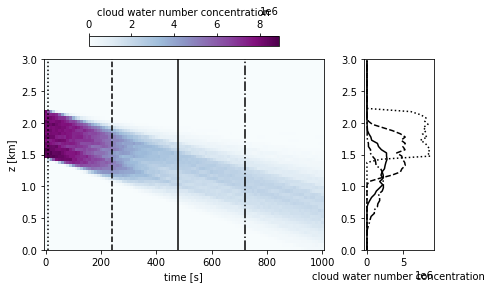

HTML(value="<a href='./nc_rhow=0.pdf' target='_blank'>./nc_rhow=0.pdf</a><br>")

In [6]:
for rho_times_w in (0,):
    plot(var='nc', qlabel='cloud water number concentration', fname=f'nc_rhow={rho_times_w}.pdf',
            output=output[f'rhow={rho_times_w}.0'],
            line = {0.01: ":", 4: "--", 8: "-", 12: "-."})

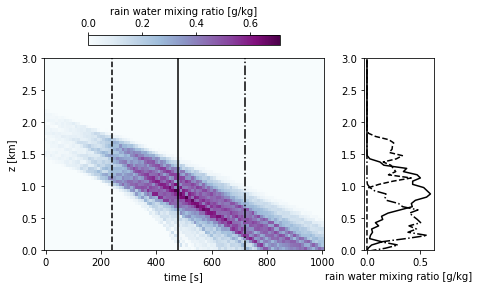

HTML(value="<a href='./qr_rhow=0.pdf' target='_blank'>./qr_rhow=0.pdf</a><br>")

In [7]:
p = True
for rho_times_w in (0,):
    plot(var='rain water mixing ratio', qlabel='rain water mixing ratio [g/kg]', fname=f'qr_rhow={rho_times_w}.pdf',
         output=output[f'rhow={rho_times_w}.0'],
         line = {0: ":", 4: "--", 8: "-", 12: "-."})

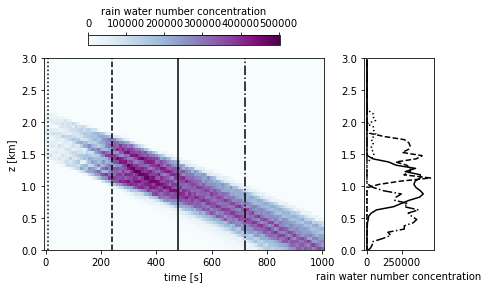

HTML(value="<a href='./nr_rhow=0.pdf' target='_blank'>./nr_rhow=0.pdf</a><br>")

In [8]:
for rho_times_w in (0,):
    plot(var='nr', qlabel='rain water number concentration', fname=f'nr_rhow={rho_times_w}.pdf',
            output=output[f'rhow={rho_times_w}.0'],
            line = {0.01: ":", 4: "--", 8: "-", 12: "-."})

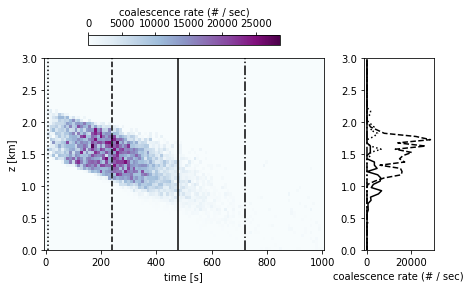

HTML(value="<a href='./coal_rhow=0.pdf' target='_blank'>./coal_rhow=0.pdf</a><br>")

In [9]:
p = True
for rho_times_w in (0,):
    plot(var='coalescence_rate', qlabel='coalescence rate (# / sec)', fname=f'coal_rhow={rho_times_w}.pdf',
         output=output[f'rhow={rho_times_w}.0'],
         line = {0.01: ":", 4: "--", 8: "-", 12: "-."})

## Comparisons

In [10]:
z_cloudy = np.linspace(0.0, 3000.0, 20) / 1000
nc_cloudy = np.array([
    [0.002325942800455995, 0.0028045022356462572, 0.003452211545804375, 0.004361877640877965, 0.005702479217508372, 0.007812475748456827, 0.011468941392117338, 0.01888454890111773, 0.039528401551653096, 0.2356787814538211, 9.90222080639631, 9.944680372872213, 9.948230520394494, 9.92828984604994, 9.49434950135968, 0.060141075852780945, 0.023917441369691872, 0.013590312401779991, 0.00893428827291265, 0.006376138306461998],
    [0.005322014757656553, 0.010480022319206528, 0.025889114642834388, 0.07027637984750808, 0.1846578336060549, 0.4341420453704166, 0.8709339382008977, 1.4526980887520684, 2.016594898467415, 2.4045238186923696, 2.579754970394283, 2.578563190147033, 2.3791690313423275, 1.7682308790889112, 0.7721032508385711, 0.01991858759231357, 0.010155146035355484, 0.0057644342569305234, 0.002836371204245902, 0.0008570715559907928],
    [0.08662893464816847, 0.15520311679346102, 0.2522813401209703, 0.371195396866207, 0.49992082338075977, 0.6298742026425381, 0.7609509414360253, 0.8962365323250485, 1.0294941603786836, 1.1334184385711124, 1.1568860052088945, 1.0412336653823127, 0.7660356607147669, 0.4068380577304884, 0.12130475619620494, 0.007647406381002058, 0.0038766052508024296, 0.0018366503445636489, 0.0006757763437823614, 0.00014251192022876204],
    [0.19820963209310652, 0.2528661807124882, 0.3158570884138644, 0.38364913993931354, 0.4493832884815257, 0.5027490610084232, 0.5311511760149372, 0.5227660441149257, 0.4715289221976368, 0.3822917550688269, 0.27222944741946864, 0.16541480707209608, 0.08242031539019055, 0.03156306801519871, 0.00795647799253679, 0.0011153510331640794, 0.0004884291395013965, 0.00018766025678891934, 5.6861581517651256e-5, 1.0878733924819186e-5],
])

qc_cloudy = np.array([
    [0.00023259428004559948, 0.0002804502235646257, 0.0003452211545804375, 0.0004361877640877965, 0.0005702479217508372, 0.0007812475748456827, 0.0011468941392117338, 0.0018884548901117728, 0.003952840155165309, 0.02356787814538211, 0.9902220806396309, 0.9944680372872212, 0.9948230520394494, 0.992828984604994, 0.9494349501359681, 0.0060141075852780945, 0.002391744136969187, 0.0013590312401779991, 0.0008934288272912649, 0.0006376138306461998],
    [0.0007446008324123797, 0.0017062385212967938, 0.0045521266894452, 0.01232248611337005, 0.030897004687650706, 0.06802160484300256, 0.1270286320846756, 0.1975947205304386, 0.25774910322755645, 0.29241568674609913, 0.30261930788409075, 0.29164719358476193, 0.2508915891345886, 0.16612800717742593, 0.061328835766217636, 0.0016661182121968014, 0.0008661265295733964, 0.000476358290888631, 0.00021705957692457706, 5.7921213943590406e-5],
    [0.01656031383026699, 0.028077798198055417, 0.042926091821587964, 0.059297486773231455, 0.07508578878498474, 0.08928990048440437, 0.1023228797711026, 0.11475197203548103, 0.12539200432700545, 0.13008943253916275, 0.12258521422776973, 0.09864887346844652, 0.06227244046416078, 0.027129943467786286, 0.006445011737676357, 0.000519163514737142, 0.0002532092239246288, 0.00010820782161964733, 3.4068535970606276e-5, 5.79220821416827e-6],
    [0.030757168729973833, 0.0373735991829509, 0.04434591786357304, 0.05090713814014857, 0.05590771651108847, 0.05797636144416201, 0.05590303149164768, 0.04921078599960091, 0.038700625460403475, 0.026521223162384176, 0.015391250719866753, 0.0073065234193505635, 0.00271332219262275, 0.0007486848626273913, 0.00015588378375704442, 3.626367328902605e-5, 1.308012805783289e-5, 3.771780816369582e-6, 7.63771805417599e-7, 8.110312094613359e-8]
])

nr_cloudy = np.array([
    [2.3259428004559948e-10, 2.804502235646257e-10, 3.4522115458043745e-10, 4.361877640877965e-10, 5.702479217508372e-10, 7.812475748456827e-10, 1.1468941392117337e-9, 1.888454890111773e-9, 3.952840155165309e-9, 2.356787814538211e-8, 9.90222080639631e-7, 9.944680372872212e-7, 9.948230520394495e-7, 9.92828984604994e-7, 9.494349501359681e-7, 6.014107585278094e-9, 2.391744136969187e-9, 1.359031240177999e-9, 8.934288272912649e-10, 6.376138306461997e-10],
    [0.0003533420532791116, 0.0012826071194146278, 0.00424553213537039, 0.012673002046450213, 0.03362575699559721, 0.07780646668937528, 0.15331141994790556, 0.2511957333816394, 0.33814936627199305, 0.3780523095075203, 0.3598088317322889, 0.2931296678544589, 0.19341647440335039, 0.08651190873395816, 0.01810784482882837, 4.1494189890466366e-6, 1.094349113436064e-6, 3.546676197032568e-7, 9.14315623350356e-8, 1.2064015228861402e-8],
    [0.04286183602944602, 0.06852467872215309, 0.09903215887493476, 0.12997070440033048, 0.15687232059974845, 0.17740978878087613, 0.19118547711395129, 0.19691911172103171, 0.18984923336031656, 0.16372127417779328, 0.11889273491240387, 0.06789317377731022, 0.02793297053418389, 0.007207574524451838, 0.0008713383759906845, 7.702005312220904e-7, 2.014372171094809e-7, 4.725224070296279e-8, 7.766049118140948e-9, 6.427033141822792e-10],
    [0.061874092050410494, 0.07128188742881585, 0.08111795686596689, 0.08980451732153531, 0.09449050033043897, 0.09134074347469225, 0.07752987289413114, 0.05487127635724207, 0.030981982591521077, 0.013660394132669304, 0.004693803464682259, 0.001247946986806364, 0.0002471714862400846, 3.290890468105509e-5, 2.207068943645234e-6, 1.0190141478651551e-8, 2.047865946736227e-9, 3.3636644705214316e-10, 3.774223029783484e-11, 1.9828529963408933e-12],
])

qr_cloudy = np.array([
    [2.3259428004559948e-10, 2.804502235646257e-10, 3.4522115458043745e-10, 4.361877640877965e-10, 5.702479217508372e-10, 7.812475748456827e-10, 1.1468941392117337e-9, 1.888454890111773e-9, 3.952840155165309e-9, 2.356787814538211e-8, 9.90222080639631e-7, 9.944680372872212e-7, 9.948230520394495e-7, 9.92828984604994e-7, 9.494349501359681e-7, 6.014107585278094e-9, 2.391744136969187e-9, 1.359031240177999e-9, 8.934288272912649e-10, 6.376138306461997e-10],
    [0.00035200151617089407, 0.0013111967057274174, 0.0044786571531358664, 0.013892547736570221, 0.03863471127263126, 0.09460221788307477, 0.19892355317632127, 0.34815123733343706, 0.491830001583502, 0.5511897143312499, 0.4932820778423064, 0.3591619186873109, 0.20663782645801065, 0.0795659654091024, 0.014340018974944115, 2.6031739369300225e-6, 6.868825051011121e-7, 2.2197596523612783e-7, 5.69233748241551e-8, 7.456832323236176e-9],
    [0.11482311944110231, 0.1953165800079347, 0.2975360397035871, 0.40314885321904576, 0.4844836094841661, 0.5176110996740826, 0.49495233107947906, 0.4267437023807917, 0.3323077368114287, 0.23095573846997497, 0.1386092144185074, 0.06764570083287864, 0.024471513975755962, 0.005687897829495739, 0.0006318064836266766, 4.7346216121926047e-7, 1.2338769749465383e-7, 2.8730188420905227e-8, 4.6732350569938025e-9, 3.823035518651779e-10],
    [0.2051516890449052, 0.17270749883053185, 0.14171673193376189, 0.11262150188264747, 0.08580121859435079, 0.06174295102301346, 0.04112156435049741, 0.02469744659130083, 0.012972304357154157, 0.005761888080833301, 0.002087794572011011, 0.0005919792707091766, 0.00012376637910333285, 1.7087512894278817e-5, 1.1819761014876744e-6, 5.503422402098125e-9, 1.0561195797504775e-9, 1.6226072373027708e-10, 1.7126710513565556e-11, 9.041044132623166e-13],
])

In [11]:
p = True
for rho_times_w in (0,):
    key = f"rhow={rho_times_w}.0"
    filename = 'products_' + key + 'collisions.nc'
    nc_exporter = NetCDFExporter_1d(output[key], settings[key], simulation[key], filename)
    nc_exporter.run()

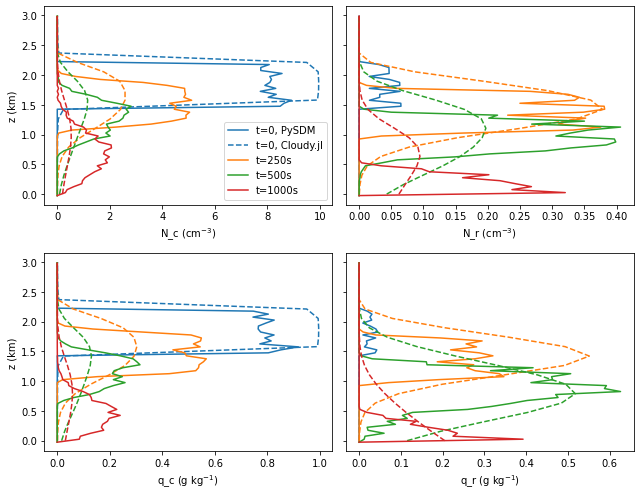

In [12]:
plt_times = [0, 250, 500, 1000]
dt = common_params["dt"]
dz = common_params["dz"] / 1000

(fig, ax) = plt.subplots(nrows=2, ncols=2, sharey=True, figsize=(9,7))
for (j,t) in enumerate(plt_times):
    it = int(t / dt)
    profiles = output[f'rhow={rho_times_w}.0']
    nc = profiles['nc'][:,it] * si.cm**3 
    nr = profiles['nr'][:,it] * si.cm**3
    qc = profiles['cloud water mixing ratio'][:,it]
    qr = profiles['rain water mixing ratio'][:,it]

    if j == 0:
        lbl = 't=0, PySDM'
        lbl2 = 't=0, Cloudy.jl'
    else:
        lbl = 't='+str(t)+'s'
        lbl2 = '_'
    line = ax[0][0].plot(nc, profiles['z']/1000, label=lbl)
    ax[0][0].plot(nc_cloudy[j], z_cloudy, '--', color=line[-1].get_color(), label=lbl2)
    line = ax[0][1].plot(nr, profiles['z']/1000)
    ax[0][1].plot(nr_cloudy[j], z_cloudy, '--', color=line[-1].get_color())
    line = ax[1][0].plot(qc, profiles['z']/1000)
    ax[1][0].plot(qc_cloudy[j], z_cloudy, '--', color=line[-1].get_color())
    line = ax[1][1].plot(qr, profiles['z']/1000)
    ax[1][1].plot(qr_cloudy[j], z_cloudy, '--', color=line[-1].get_color())

ax[0][0].set_xlabel('N_c (cm$^{-3}$)')
ax[0][0].set_ylabel('z (km)')
ax[0][0].legend()
ax[0][1].set_xlabel('N_r (cm$^{-3}$)')
ax[1][0].set_xlabel('q_c (g kg$^{-1}$)')
ax[1][0].set_ylabel('z (km)')
ax[1][1].set_xlabel('q_r (g kg$^{-1}$)')

plt.tight_layout()
plt.savefig('rainshaft.pdf')